This code is referenced from the following repository:
https://github.com/XiuzeZhou/RUL

D. Chen, W. Hong and X. Zhou, "Transformer Network for Remaining Useful Life Prediction of Lithium-Ion Batteries," in IEEE Access, vol. 10, pp. 19621-19628, 2022.

In [37]:
import numpy as np
import random
import math
import time
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
%matplotlib inline



def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)







Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = '../CALCE/'
Battery, capacity = {}, []
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']


            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))
                d_c = (d_c[1:]+d_c[:-1])/2
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result
    capacity.append(df_result['capacity'])
data = pd.concat(capacity, axis=1)
data.columns = Battery_list
data.to_csv('data.csv', index=False)
print('Save data.csv ...')









Load Dataset CS2_35 ...
Load ../CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_12_23_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_1_10_11.xlsx ...
Load ../CALCE/CS2_35\CS2_35_1_18_11.xlsx ...
Load ../CALCE/CS2_35\CS2_35_1_24_11.xlsx ...
Load ../CALCE/CS2_35\CS2_35_1_28_11.xlsx ...
Load ../CALCE/CS2_35\CS2_35_2_10_11.xlsx ...
Load ../CALCE/CS2_35\CS2_35_2_4_11.xlsx ...
Load ../CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_8_18_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_8_19_10.xlsx ...
Load ../CALCE/CS2_35\CS2_35_8_30_10.xlsx ...
Load ../CALCE/CS2_35\

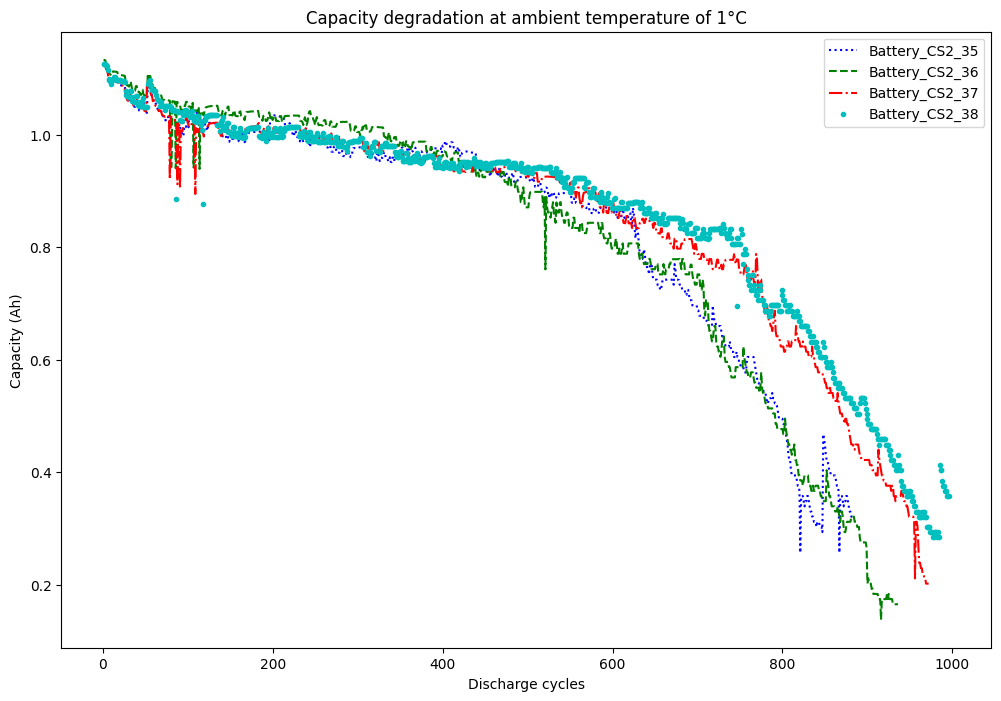

In [39]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']


# data = pd.read_csv('data.csv')
# plt.figure(figsize=(12, 8))
# for name in Battery_list:
#     plt.plot(data[name], label=name)
# plt.legend()



Battery = np.load('CALCE.npy', allow_pickle=True)
Battery = Battery.item()

# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()